In [2]:
import torch
import torchvision.transforms as T

import PIL

import os
import random
import cv2
import numpy as np

# from matplotlib import pyplot as plt 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
import copy
import json
import multiprocessing

from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn

In [3]:
annotations_file = "/project/trinity/datasets/APRICOT_ORIGINAL/Annotations/apricot_annotations_test.json"

with open(annotations_file, 'r') as file:
    data = json.load(file)

annotations_coco_91 = {}
for i in range(len(data['categories'])):
    annotations_coco_91[data['categories'][i]['id']] = data['categories'][i]['name']

patch_id_to_target = {}
for i in range(len(data['patches'])):
    patch_id_to_target[data['patches'][i]['id']] = data['patches'][i]['adv_target']

In [4]:
def processData(filePath, scale=1.0, shape=(512,512)):
    img_info = torch.load(filePath)
    img = np.squeeze(img_info['Image'])
    h, w, _ = img.shape

    if shape is None:
        shape = (h//8, w//8)

    # img = (255.0 * img).astype(np.uint8)

    # img = cv2.resize(img, (int(w * scale), int(h * scale)))
    img = cv2.resize(img, shape)
    img = torch.from_numpy(np.transpose(img, (2,0,1)))
    # imgs.append(img)

    mask = np.squeeze(img_info['Mask'])
    mask = (255.0 * mask).astype(np.uint8)

    # mask = cv2.resize(mask, (int(w * scale), int(h * scale)))
    mask = cv2.resize(mask, shape)

    # Make a rectangular mask
    nonzero_indices = np.nonzero(mask)
    min_row = np.min(nonzero_indices[0])
    max_row = np.max(nonzero_indices[0])
    min_col = np.min(nonzero_indices[1])
    max_col = np.max(nonzero_indices[1])
    mask[min_row:max_row+1, min_col:max_col+1] = 255

    # masks.append(mask)


    bounding_boxes = img_info['Annotations'][0]['boxes']
    bboxes = np.reshape(bounding_boxes, (bounding_boxes.shape[1], bounding_boxes.shape[2]))        
    bboxes[:, 2] = ((bboxes[:, 2] - bboxes[:, 0]) * img.shape[1]).astype(int)
    bboxes[:, 3] = ((bboxes[:, 3] - bboxes[:, 1]) * img.shape[2]).astype(int)
    bboxes[:, 0] = (img.shape[1] * bboxes[:, 0]).astype(int)
    bboxes[:, 1] = (img.shape[2] * bboxes[:, 1]).astype(int)

    # all_bboxes.append(bboxes)

    labels = img_info['Annotations'][0]['labels']
    labels = np.reshape(labels, (labels.shape[1]))
    # all_labels.append(labels)

    patch_id_list = img_info['Annotations'][0]['patch_id']
    patch_id = patch_id_list[0][np.nonzero(patch_id_list[0] >= 0)[0][0]]
    # patch_ids.append(patch_id)
    res = (img, mask, bboxes, labels, patch_id)
    return res

def getImagesInfo(num_images=1, scale=1.0, shape=(512,512), random=True, dataset_path=None):
    apricot_dataset = dataset_path
    num_processes = multiprocessing.cpu_count()
    file_paths = [os.path.join(apricot_dataset, filename) for filename in os.listdir(apricot_dataset)]

    if random:
        file_paths = random.sample(file_paths, num_images)
    else:
        file_paths = file_paths[:num_images]

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(processData, file_paths)

    return results


In [5]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxA_area = (boxA[2] + 1) * (boxA[3] + 1)
    boxB_area = (boxB[2] + 1) * (boxB[3] + 1)

    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
    return iou

def getPatchBbox(patch_bbox, all_adversarial_bboxes, adversarial_scores, iou_threshold=0.1, score_threshold=0.3):
    adversarial_patch_idx = -1
    curr_max_iou = 0

    for j in range(all_adversarial_bboxes.shape[0]):
        if adversarial_scores[j] > score_threshold:
            iou = calculate_iou(patch_bbox, all_adversarial_bboxes[j])
            if iou >= iou_threshold:
                if iou > curr_max_iou:
                    curr_max_iou = iou
                    adversarial_patch_idx = j

    return adversarial_patch_idx

In [6]:
def attackSuccessRate(num_images, all_bboxes, all_labels, all_patch_ids, adv_predictions, iou_threshold=0.1, score_threshold=0.3, print_iter=50):
    targeted_success = 0
    untargeted_success = 0
    plot_titles = ["Unsuccessful", "Untargeted Success", "Targeted Success"]
    attack_state = 0

    for i in range(num_images):
        attack_state = 0
        
        for j in range(all_bboxes[i].shape[0]):
            if all_labels[i][j] == -10:
                patch_bbox = np.array([all_bboxes[i][j][1], all_bboxes[i][j][0], all_bboxes[i][j][3], all_bboxes[i][j][2]])
        
        ########## ADVERSARIAL BOUNDING BOXES ###############

        adversarial_bboxes = copy.deepcopy(adv_predictions[i]['boxes'].detach().numpy())
        adversarial_bboxes[:, 2] = (adversarial_bboxes[:, 2] - adversarial_bboxes[:, 0]).astype(int)
        adversarial_bboxes[:, 3] = (adversarial_bboxes[:, 3] - adversarial_bboxes[:, 1]).astype(int)
        adversarial_bboxes[:, 0] = (adversarial_bboxes[:, 0]).astype(int)
        adversarial_bboxes[:, 1] = (adversarial_bboxes[:, 1]).astype(int)

        # Get the bounding box for the patch and check it's label

        adversarial_labels = adv_predictions[i]['labels'].detach().numpy()
        adversarial_scores = adv_predictions[i]['scores'].detach().numpy()

        adversarial_patch_idx = getPatchBbox(patch_bbox, adversarial_bboxes, adversarial_scores, iou_threshold, score_threshold)
        
        if adversarial_patch_idx != -1:
            attack_state = 1
            untargeted_success += 1
            if patch_id_to_target[all_patch_ids[i]] == adversarial_labels[adversarial_patch_idx]:
                targeted_success += 1
                attack_state = 2

        if (i+1) % print_iter == 0:
            print("Num Images Completed {}".format(i+1))
    return targeted_success, untargeted_success

In [7]:
def _main(numImages, datasetPath, model, printIter=50):
    dataset_path = datasetPath
    num_images = numImages
    iou_threshold = 0.1
    score_threshold = 0.3

    results = getImagesInfo(num_images=num_images, scale=0.20, shape=None, random=False, dataset_path=dataset_path)

    print("Loading Images Completed")

    adv_imgs = [row[0] for row in results]
    mask = [row[1] for row in results]
    all_bboxes = [row[2] for row in results]
    all_labels = [row[3] for row in results]
    all_patch_ids = [row[4] for row in results]

    adv_predictions = model(adv_imgs)

    targeted_success, untargeted_success = attackSuccessRate(num_images, all_bboxes, all_labels, all_patch_ids, adv_predictions, iou_threshold, score_threshold, print_iter=printIter)
    return targeted_success, untargeted_success

In [45]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

apricot_test_dataset = "/project/trinity/datasets/apricot/pub/apricot-mask/data_mask_v2"
apricot_files = os.listdir(apricot_test_dataset)
num_test_images = len(apricot_files)

test_targeted_success, test_untargeted_success = _main(num_test_images, apricot_test_dataset, model)

Num Images Completed 50
Num Images Completed 100
Num Images Completed 150
Num Images Completed 200
Num Images Completed 250
Num Images Completed 300
Num Images Completed 350
Num Images Completed 400
Num Images Completed 450
Num Images Completed 500
Num Images Completed 550
Num Images Completed 600
Num Images Completed 650
Num Images Completed 700
Num Images Completed 750
Num Images Completed 800
Num Images Completed 850


In [25]:
test_targeted_success_rate = test_targeted_success * 100.0 / num_test_images
test_untargeted_success_rate = test_untargeted_success * 100.0 / num_test_images

print("Targeted Success : {}".format(test_targeted_success_rate))
print("Untargeted Success : {}".format(test_untargeted_success_rate))

Targeted Success : 6.414662084765178
Untargeted Success : 42.955326460481096


In [8]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

apricot_dev_dataset = "/project/trinity/datasets/apricot/pub/apricot-mask/dev/data_mask_v2"
apricot_files = os.listdir(apricot_dev_dataset)
num_dev_images = len(apricot_files)

dev_targeted_success, dev_untargeted_success = _main(num_dev_images, apricot_dev_dataset, model, 20)

Loading Images Completed
Num Images Completed 20
Num Images Completed 40
Num Images Completed 60
Num Images Completed 80
Num Images Completed 100
Num Images Completed 120


In [9]:
dev_targeted_success_rate = dev_targeted_success * 100.0 / num_dev_images
dev_untargeted_success_rate = dev_untargeted_success * 100.0 / num_dev_images

print("Targeted Success : {}".format(dev_targeted_success_rate))
print("Untargeted Success : {}".format(dev_untargeted_success_rate))

Targeted Success : 7.246376811594203
Untargeted Success : 63.768115942028984


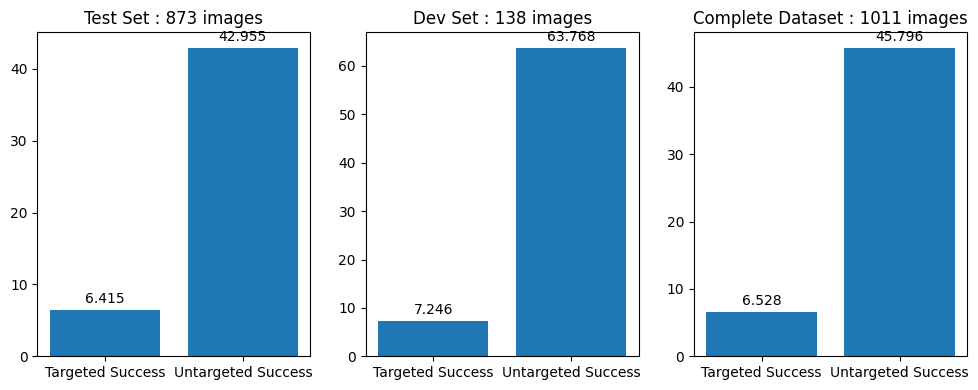

In [26]:
labels = ['Targeted Success', 'Untargeted Success']

test_data = [test_targeted_success_rate, test_untargeted_success_rate]

dev_data = [dev_targeted_success_rate, dev_untargeted_success_rate]

entire_data = [(test_targeted_success + dev_targeted_success) * 100.0 / (num_test_images + num_dev_images), 
               (test_untargeted_success + dev_untargeted_success) * 100.0 / (num_test_images + num_dev_images)]


fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].set_title('Test Set : {} images'.format(num_test_images))

bars = axs[0].bar(labels, test_data)

for bar, value in zip(bars, test_data):
    height = bar.get_height()
    axs[0].annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')


axs[1].set_title('Dev Set : {} images'.format(num_dev_images))

bars = axs[1].bar(labels, dev_data)

for bar, value in zip(bars, dev_data):
    height = bar.get_height()
    axs[1].annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')


axs[2].set_title('Complete Dataset : {} images'.format(num_test_images + num_dev_images))

bars = axs[2].bar(labels, entire_data)

for bar, value in zip(bars, entire_data):
    height = bar.get_height()
    axs[2].annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')
# Show the plots
plt.tight_layout()
plt.show()